<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/vgg_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d erhmrai/ecg-image-data

100% 857M/858M [00:21<00:00, 42.8MB/s]
100% 858M/858M [00:21<00:00, 41.7MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-image-data.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report

(288, 432, 3)


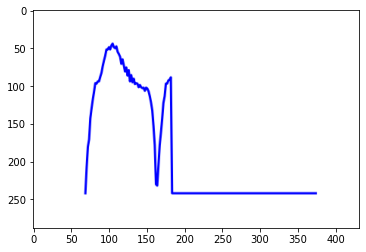

In [5]:
import cv2
path =r'/content/ECG_Image_data/test/S/S1070.png'
#x=plt.imread(path)
x = cv2.imread(path)
print(x.shape)
plt.imshow(x)

In [6]:
train_dir = Path('/content/ECG_Image_data/train')

filepaths = list(train_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG_Image_data/train/Q/Q1039.png,Q
1,/content/ECG_Image_data/train/Q/Q7206.png,Q
2,/content/ECG_Image_data/train/Q/Q367.png,Q
3,/content/ECG_Image_data/train/Q/Q4548.png,Q
4,/content/ECG_Image_data/train/Q/Q6629.png,Q
...,...,...
99194,/content/ECG_Image_data/train/M/M2469.png,M
99195,/content/ECG_Image_data/train/M/M5724.png,M
99196,/content/ECG_Image_data/train/M/M8708.png,M
99197,/content/ECG_Image_data/train/M/M9175.png,M


In [7]:
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [8]:
samples = []
for category in dataframe['Label'].unique():
    category_slice = dataframe.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

Q    640
S    640
N    640
M    640
F    640
V    640
Name: Label, dtype: int64

In [9]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/Q/Q6407.png,Q
1,/content/ECG_Image_data/train/S/S1238.png,S
2,/content/ECG_Image_data/train/N/N10626.png,N
3,/content/ECG_Image_data/train/N/N92838.png,N
4,/content/ECG_Image_data/train/M/M8289.png,M
...,...,...
3835,/content/ECG_Image_data/train/N/N4068.png,N
3836,/content/ECG_Image_data/train/F/F40.png,F
3837,/content/ECG_Image_data/train/F/F799.png,F
3838,/content/ECG_Image_data/train/Q/Q2081.png,Q


In [10]:
test_dir = Path('/content/ECG_Image_data/test')

filepaths = list(test_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/Q/Q2513.png,Q
1,/content/ECG_Image_data/test/Q/Q5854.png,Q
2,/content/ECG_Image_data/test/Q/Q7493.png,Q
3,/content/ECG_Image_data/test/Q/Q3968.png,Q
4,/content/ECG_Image_data/test/Q/Q2804.png,Q
...,...,...
24794,/content/ECG_Image_data/test/M/M1245.png,M
24795,/content/ECG_Image_data/test/M/M935.png,M
24796,/content/ECG_Image_data/test/M/M646.png,M
24797,/content/ECG_Image_data/test/M/M400.png,M


In [11]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [12]:
samples = []
for category in dataframe_test['Label'].unique():
    category_slice = dataframe_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

F    160
M    160
S    160
Q    160
V    160
N    160
Name: Label, dtype: int64

In [13]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/F/F309.png,F
1,/content/ECG_Image_data/test/M/M1867.png,M
2,/content/ECG_Image_data/test/S/S1423.png,S
3,/content/ECG_Image_data/test/S/S1021.png,S
4,/content/ECG_Image_data/test/S/S2257.png,S
...,...,...
955,/content/ECG_Image_data/test/N/N26117.png,N
956,/content/ECG_Image_data/test/Q/Q119.png,Q
957,/content/ECG_Image_data/test/M/M1906.png,M
958,/content/ECG_Image_data/test/F/F184.png,F


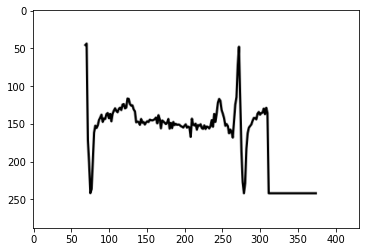

In [14]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [15]:
array_image = img_to_array(img)
print(array_image.shape)

(288, 432, 3)


In [16]:
'''train_generator2 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    validation_split=0.2
  
)

test_generator2 = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
)'''
train_datagen = ImageDataGenerator(rescale= 1./255,
                   shear_range = 0.2,
                   horizontal_flip=True,
                   zoom_range = 0.2,
                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale= 1./255)

In [17]:
'''train_images = train_generator2.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator2.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator2.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)'''
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        subset='training',
        class_mode= "categorical")
val_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        subset='validation',
        class_mode= "categorical")
test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size= (224,224),
        batch_size = 32,
        color_mode= "rgb",
        class_mode= "categorical")

Found 79362 images belonging to 6 classes.
Found 19837 images belonging to 6 classes.
Found 24799 images belonging to 6 classes.


In [18]:
'''from tensorflow.keras.applications.vgg16 import VGG16

pretrained_model2 = VGG16(
                          input_shape=(224,224,3),
                          include_top= False,
                          weights='imagenet',
                          pooling='avg'
                          )

pretrained_model2.trainable = False'''
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 3s 0us/step


In [19]:
for layer in vgg.layers:
  layer.trainable = False

In [20]:
x2 = Flatten()(vgg.output)

In [21]:
folders=glob('/content/ECG_Image_data/test/*')
folders

['/content/ECG_Image_data/test/Q',
 '/content/ECG_Image_data/test/F',
 '/content/ECG_Image_data/test/S',
 '/content/ECG_Image_data/test/V',
 '/content/ECG_Image_data/test/N',
 '/content/ECG_Image_data/test/M']

In [22]:
prediction2 = Dense(len(folders), activation='softmax')(x2)

In [23]:
'''vgg_model = Sequential ([
                        pretrained_model2,
                        Flatten(),
                        Dropout(0.2),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(6, activation='softmax')
                    ])'''
vgg_model = Model(inputs=vgg.input, outputs=prediction2)

vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:

import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)


In [27]:
history=vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//64, #len(train_generator),
    validation_data=val_generator,
    validation_steps=val_generator.samples//64, #len(val_generator),
    epochs=15,
    callbacks=[checkpoint]
)

<ipython-input-27-142a92ce4644>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=vgg_model.fit_generator(


Epoch 1/15
1240/1240 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9955
Epoch 1: val_accuracy improved from -inf to 0.99889, saving model to best_model.h5
1240/1240 [==============================] - 659s 532ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0045 - val_accuracy: 0.9989
Epoch 2/15
1240/1240 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9955
Epoch 2: val_accuracy did not improve from 0.99889
1240/1240 [==============================] - 654s 527ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0133 - val_accuracy: 0.9956
Epoch 3/15
1240/1240 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9988
Epoch 3: val_accuracy improved from 0.99889 to 0.99970, saving model to best_model.h5
1240/1240 [==============================] - 640s 516ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 7.2404e-04 - val_accuracy: 0.9997
Epoch 4/15
1240/1240 [==============================] - ETA: 0s - loss:

In [28]:
from keras.models import load_model
best_model=load_model('best_model.h5')
results = best_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00003
Test Accuracy: 100.00%


Text(0, 0.5, 'accuracy')

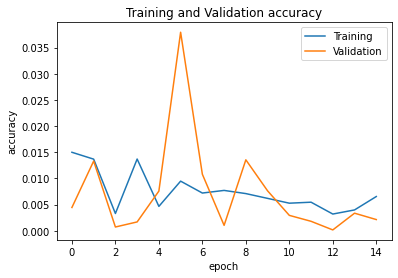

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

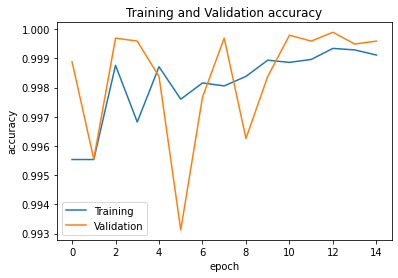

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [31]:
y_pred = best_model.predict(test_generator)
y_pred

775/775 [==============================] - 134s 172ms/step


array([[9.7125787e-15, 1.4181141e-20, 9.9999952e-01, 6.7914244e-22,
        2.1210619e-18, 4.2569130e-07],
       [2.4411673e-20, 4.7629865e-30, 4.8681174e-21, 8.3439825e-29,
        1.7866200e-16, 1.0000000e+00],
       [5.0771224e-22, 2.4115739e-30, 1.0000000e+00, 1.3472170e-25,
        1.9296015e-24, 4.0201882e-19],
       ...,
       [3.3676325e-16, 3.0323823e-22, 1.0000000e+00, 5.2067016e-18,
        1.2563788e-22, 3.3413268e-14],
       [2.4765098e-20, 5.6035875e-24, 1.0000000e+00, 8.6496867e-17,
        3.1451685e-28, 1.8087613e-18],
       [1.8514950e-15, 4.9229621e-22, 9.9999988e-01, 2.9268567e-22,
        6.0514073e-19, 1.2076646e-07]], dtype=float32)

In [32]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([2, 5, 2, ..., 2, 2, 2])

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[    1    11   123    11     2    13]
 [   15   170  1630   128    49   109]
 [  121  1600 14422  1256   428  1099]
 [   10   137  1234    91    32   104]
 [    5    48   429    31     9    34]
 [    9   135  1088    91    36    88]]
classification report
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       161
           1       0.08      0.08      0.08      2101
           2       0.76      0.76      0.76     18926
           3       0.06      0.06      0.06      1608
           4       0.02      0.02      0.02       556
           5       0.06      0.06      0.06      1447

    accuracy                           0.60     24799
   macro avg       0.16      0.16      0.16     24799
weighted avg       0.60      0.60      0.60     24799

